#### Imports

In [1]:
using Plots
using Random
using JuMP
using LinearAlgebra
using Graphs
using GraphPlot

import HiGHS


# Motion Planning Using Convex Optimization

## Utils

In [2]:
function Factorial(n::Int64)
    if n == 0 || n == 1
        return 1;
    else
        return n*Factorial(n-1);
    end
end

function BinomialCoefficient(k::Int64, d::Int64)
    return Factorial(d)/(Factorial(k)*(Factorial(d-k)))
end

BinomialCoefficient (generic function with 1 method)

## Model

In [3]:
struct Point
    x::Float64
    y::Float64
end

function PointAsVector(point::Point)
    vector::Vector{Float64}  = [point.x, point.y]
    return vector
end

function PointFromVector(vector::Vector{Float64})
    return Point(vector[1],vector[2])
end

PointFromVector (generic function with 1 method)

In [4]:
mutable struct PointListNode
    point::Union{Point,Nothing}
    nextNode::Union{PointListNode,Nothing}
end

mutable struct CircularPointList
    head::Union{PointListNode,Nothing}
    tail::Union{PointListNode,Nothing}
    length::Int64
end

function PushIntoCircularPointList(list::CircularPointList, point::Point)
    newListNode::PointListNode = PointListNode(point,nothing);

    if nothing == list.head || nothing == list.tail
        newListNode.nextNode = newListNode
        list.head = newListNode
        list.tail = newListNode

    elseif list.head.nextNode == list.head
        newListNode.nextNode = list.head
        list.head.nextNode = newListNode
        list.tail = newListNode
    else
        list.tail.nextNode = newListNode
        list.tail = newListNode;
        newListNode.nextNode = list.head
    end
    list.length = list.length + 1;
end

PushIntoCircularPointList (generic function with 1 method)

In [5]:
# always in clockwise direction
struct Polygon
    pointList::CircularPointList
end

function PrintPolygon(polygon::Polygon, p::Union{Plots.Plot{Plots.GRBackend},Nothing}=nothing)

    currentNode::PointListNode = polygon.pointList.head;
    pointNumber::Int64 = polygon.pointList.length + 1

    xAxis = []
    yAxis = []

    for i = 1:pointNumber
        append!(xAxis,currentNode.point.x)
        append!(yAxis,currentNode.point.y)
        currentNode = currentNode.nextNode
    end

    if nothing == p
        p = scatter(xAxis, yAxis,legend=false);
        plot!(p,xAxis, yAxis,legend=false)
    else
        scatter!(p,xAxis, yAxis,legend=false);
        plot!(p,xAxis, yAxis,legend=false)
    end

    return p
end

function GeneratePolygonConstraintMatrix(polygon::Polygon)
    
    constraintMatrix::Vector{Vector{Float64}} = [];    
    constraintVector::Vector{Float64} = [];
    initialVertex = polygon.pointList.head;
    finalVertex = polygon.pointList.head.nextNode;

    for i = 1:(polygon.pointList.length)
        isFaceVertical = false
        isFaceHorizontal = false
    
        if finalVertex.point.x == initialVertex.point.x 
            isFaceVertical = true
        end

        if finalVertex.point.y == initialVertex.point.y
            isFaceHorizontal = true
        end

        if isFaceVertical
            if finalVertex.point.y > initialVertex.point.y
                append!(constraintMatrix, [[-1.0,0.0]])
                append!(constraintVector, -initialVertex.point.x)
            else
                append!(constraintMatrix, [[1.0,0.0]])
                append!(constraintVector, initialVertex.point.x)
            end
        elseif isFaceHorizontal
            if finalVertex.point.x < initialVertex.point.x
                append!(constraintMatrix, [[0.0,-1.0]])
                append!(constraintVector, -initialVertex.point.y)
            else
                append!(constraintMatrix, [[0.0,1.0]])
                append!(constraintVector, initialVertex.point.y)
            end
        else
            # to be implemented
        end
        
        initialVertex = initialVertex.nextNode;
        finalVertex = finalVertex.nextNode;

    end

    return mapreduce(permutedims, vcat, constraintMatrix),constraintVector

end

function IsPointInPolygon(polyong::Polygon, point::Point)
    A, b = GeneratePolygonConstraintMatrix(polyong)
    return prod(A*PointAsVector(point).<= b)
end

function ArePolygonsAdjacent(thisPolygon::Polygon, thatPolygon::Polygon)
    thisPolygonNumberFaces = thisPolygon.pointList.length
    thatPolygonNumberFaces = thatPolygon.pointList.length

    arePolygonsAdjacent = false;

    thisPolygonCurrentInitialVertex = thisPolygon.pointList.head
    thatPolygonCurrentInitialVertex = thatPolygon.pointList.head

    thisPolygonCurrentFinalVertex = thisPolygon.pointList.head.nextNode
    thatPolygonCurrentFinalVertex = thatPolygon.pointList.head.nextNode

    for i = 1:(thisPolygonNumberFaces + 1)
        for j = 1:(thatPolygonNumberFaces+ 1)

            areFacesParallel = false 
            areFacesVertical = false
            areFacesHorizontal = false

            # Both faces are vertical
            if thisPolygonCurrentInitialVertex.point.x == thisPolygonCurrentFinalVertex.point.x && thatPolygonCurrentFinalVertex.point.x == thatPolygonCurrentInitialVertex.point.x
                areFacesParallel = true
                areFacesVertical = true
            
            # Both faces are horizontal 
            elseif thisPolygonCurrentInitialVertex.point.y == thisPolygonCurrentFinalVertex.point.y && thatPolygonCurrentFinalVertex.point.y == thatPolygonCurrentInitialVertex.point.y
                areFacesParallel = true
                areFacesHorizontal = true
            
            # Both faces have the same angular coefficient
            elseif (thisPolygonCurrentFinalVertex.point.y - thisPolygonCurrentInitialVertex.point.y)/(thisPolygonCurrentFinalVertex.point.x - thisPolygonCurrentInitialVertex.point.x) == (thatPolygonCurrentFinalVertex.point.y - thatPolygonCurrentInitialVertex.point.y)/(thatPolygonCurrentFinalVertex.point.x - thatPolygonCurrentInitialVertex.point.x) 
                areFacesParallel = true

            end

            if areFacesParallel

                if areFacesVertical
                    if thisPolygonCurrentInitialVertex.point.x == thatPolygonCurrentInitialVertex.point.x
                        # final vertex y > initial vertex y
                        if (thisPolygonCurrentFinalVertex.point.y >=  thatPolygonCurrentFinalVertex.point.y && thisPolygonCurrentInitialVertex.point.y <= thatPolygonCurrentFinalVertex.point.y)
                            arePolygonsAdjacent = true
                            return arePolygonsAdjacent
                        # final vertex y < initial vertex y
                        elseif (thisPolygonCurrentFinalVertex.point.y <=  thatPolygonCurrentFinalVertex.point.y && thisPolygonCurrentInitialVertex.point.y >= thatPolygonCurrentFinalVertex.point.y)
                            arePolygonsAdjacent = true
                            return arePolygonsAdjacent                        
                        end 
                    end 

                elseif areFacesHorizontal
                    if thisPolygonCurrentInitialVertex.point.y == thatPolygonCurrentInitialVertex.point.y
                        # final vertex x > initial vertex x
                        if (thisPolygonCurrentFinalVertex.point.x >=  thatPolygonCurrentFinalVertex.point.x && thisPolygonCurrentInitialVertex.point.x <= thatPolygonCurrentFinalVertex.point.x)
                            arePolygonsAdjacent = true
                            return arePolygonsAdjacent
                        # final vertex x < initial vertex x
                        elseif (thisPolygonCurrentFinalVertex.point.x <=  thatPolygonCurrentFinalVertex.point.x && thisPolygonCurrentInitialVertex.point.x >= thatPolygonCurrentFinalVertex.point.x)
                            arePolygonsAdjacent = true
                            return arePolygonsAdjacent                        
                        end 
                    end
                
                else 
                    # to be implemented
                    return false
                end

            end

            thatPolygonCurrentInitialVertex = thatPolygonCurrentInitialVertex.nextNode
            thatPolygonCurrentFinalVertex = thatPolygonCurrentFinalVertex.nextNode    
        end

        thisPolygonCurrentInitialVertex = thisPolygonCurrentInitialVertex.nextNode
        thisPolygonCurrentFinalVertex = thisPolygonCurrentFinalVertex.nextNode

    end

    return arePolygonsAdjacent;
end

ArePolygonsAdjacent (generic function with 1 method)

In [6]:
struct Map
    background::Polygon
    freeRegions::Vector{Polygon}
    obsctables::Vector{Polygon}
    sourcePoint::Point
    targetPoint::Point
end

function PrintMap(map::Map)
    p = PrintPolygon(map.background)

    for i = 1:size(map.freeRegions)[1]
        PrintPolygon(map.freeRegions[i],p)
    end

    for i = 1:size(map.obsctables)[1]
        PrintPolygon(map.obsctables[i],p)
    end
    
    scatter!(p,[map.sourcePoint.x], [map.sourcePoint.y])
    scatter!(p,[map.targetPoint.x], [map.targetPoint.y])

    return p
end

function GenerateSourceMatrixFromMap(map::Map)
    sourceMatrix = zeros(size(map.freeRegions)[1],2)
    sourceMatrix[1,1] = -1
    sourceMatrix[size(map.freeRegions)[1],2] = 1
    
    return sourceMatrix
end

function GenerateContraintMatrixForSourceRegionFromMap(map::Map)
    sourceRegion::Polygon = map.freeRegions[1]

    for i = 1:size(map.freeRegions)[1]
        if IsPointInPolygon(map.freeRegions[i], map.sourcePoint)
            sourceRegion = map.freeRegions[i]
        end
    end

    return GeneratePolygonConstraintMatrix(sourceRegion)
end

function GenerateContraintMatrixForTargetRegionFromMap(map::Map)
    targetRegion::Polygon = map.freeRegions[1]

    for i = 1:size(map.freeRegions)[1]
        if IsPointInPolygon(map.freeRegions[i], map.targetPoint)
            targetRegion = map.freeRegions[i]
        end
    end
    return GeneratePolygonConstraintMatrix(targetRegion)
end

function GenerateGraphOfConvexSetsFromMap(map::Map)
    graphOfConvexSets = DiGraph(size(map.freeRegions)[1])

    sourceRegion::Polygon = map.freeRegions[1]
    targetRegion::Polygon = map.freeRegions[1]

    for i = 1:size(map.freeRegions)[1]
        if IsPointInPolygon(map.freeRegions[i], map.sourcePoint)
            print("source: ")
            print(i)
            print("\n")
            sourceRegion = map.freeRegions[i]
        end
    
        if IsPointInPolygon(map.freeRegions[i], map.targetPoint)
            print("target: ")
            print(i)
            print("\n")
            targetRegion = map.freeRegions[i]
        end
    end

    sourceNodeIndex = findall( x -> x == sourceRegion, map.freeRegions)[1]
    targetNodeIndex = findall( x -> x == targetRegion, map.freeRegions)[1]

    sourceNode = map.freeRegions[sourceNodeIndex]


    for i = 1:size(map.freeRegions)[1]
        if i != sourceNodeIndex && ArePolygonsAdjacent(map.freeRegions[i],sourceNode)
            add_edge!(graphOfConvexSets,sourceNodeIndex,i)
        end
    end

    for e in edges(graphOfConvexSets)
        regionIndex = dst(e)
        for i = 1:size(map.freeRegions)[1]
            if i != regionIndex && i != src(e) && ArePolygonsAdjacent(map.freeRegions[regionIndex],map.freeRegions[i]) && !has_edge(graphOfConvexSets, i, regionIndex)
                add_edge!(graphOfConvexSets,regionIndex,i)
            end
        end 
    end

    return graphOfConvexSets
end

GenerateGraphOfConvexSetsFromMap (generic function with 1 method)

In [7]:
struct Pose
    position::Point
    orientation::Float64
end

In [8]:
struct BezierCurve
    controlPoints::Vector{Point}
    degree::Int64
end

function EvaluateBezierCurve(curve::BezierCurve, s::Float64)
    
    if s < 0
        s = 0
    elseif s > 1
        s = 1
    end

    value::Vector{Float64} = [0,0];

    for i = 0:curve.degree
        value = value + PointAsVector(curve.controlPoints[i+1])*BinomialCoefficient(i,curve.degree)*(s^(i))*(1-s)^(curve.degree - i)
    end

    return value
end

EvaluateBezierCurve (generic function with 1 method)

## Random Map Generation

### Random Convex Polygon Generation

In [5]:
function GenerateRandomConvexPolygon(numberOfVertices::Int64)
    # Still remains a test for convexity and 
    #keep up with the computation until a convex poligon is found
    
    xCoordinateRandomPoints = []
    yCoordinateRandomPoints = []

    for i in 1:numberOfVertices
        append!(xCoordinateRandomPoints, rand())
        append!(yCoordinateRandomPoints, rand())
    end

    sort!(xCoordinateRandomPoints)
    sort!(yCoordinateRandomPoints)

    minimumX = xCoordinateRandomPoints[1]
    maximumX = xCoordinateRandomPoints[numberOfVertices]
    minimumY = yCoordinateRandomPoints[1]
    maximumY = yCoordinateRandomPoints[numberOfVertices]


    xVectors = []
    yVectors = []

    lastTop = minimumX
    lastBot = minimumX;

    for i in 2:numberOfVertices-1
        x = xCoordinateRandomPoints[i];

        if rand(Bool)
            append!(xVectors, x - lastTop)
            lastTop = x;
        else 
            append!(xVectors, x - lastBot)
            lastBot = x;
        end
    end

    append!(xVectors, maximumX - lastTop)
    append!(xVectors, lastBot - maximumX)

    lastLeft = minimumY
    lastRight = minimumY;

    for i in 2:numberOfVertices-1
        y = yCoordinateRandomPoints[i];

        if rand(Bool)
            append!(yVectors, y - lastLeft)
            lastLeft = y;
        else 
            append!(yVectors, lastRight - y)
            lastRight = y;
        end
    end

    append!(yVectors, maximumY - lastLeft)
    append!(yVectors, lastRight - maximumY)

    shuffle(yVectors);

    points = []
    angles = []

    for i in 1:numberOfVertices
        push!(points, Point(xVectors[i],yVectors[i]))
        append!(angles, atan(yVectors[i],xVectors[i]))
    end

    order = sortperm(angles)
    

    points = points[order]

    x = 0.0
    y = 0.0
    minPolygonX = 0;
    minPolygonY = 0;
    newPoints = []
    for i in 1:numberOfVertices 
        push!(newPoints, Point(x,y))

        x += points[i].x;
        y += points[i].y;

        minPolygonX = min(minPolygonX, x)
        minPolygonY = min(minPolygonY, y)
    end
    

    xShift = minimumX - minPolygonX;
    yShift = minimumY - minPolygonY;

    for i in 1:numberOfVertices 
        p = points[i]
        points[i] = Point(p.x + xShift, p.y + yShift)
    end
    
    return points;
end


GenerateRandomConvexPolygon (generic function with 1 method)

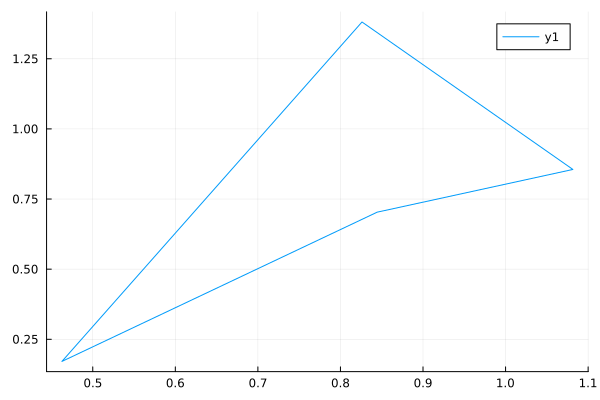

In [6]:
a = GenerateRandomConvexPolygon(4)
xs = []
ys = []
for i in 1:4
    append!(xs,a[i].x)
    append!(ys,a[i].y)
end

append!(xs,a[1].x)
append!(ys,a[1].y)

plot(xs,ys)

reference: https://cglab.ca/~sander/misc/ConvexGeneration/convex.html

In [7]:
point = Point(1,2)
point2 = Point(1,2)

Point(1.0, 2.0)

In [8]:
a = [point,point2]

push!(a, Point(1,2))

3-element Vector{Point}:
 Point(1.0, 2.0)
 Point(1.0, 2.0)
 Point(1.0, 2.0)

In [9]:
point.y

2.0

In [10]:
x = [1,2,3,4,5]
shuffle!(x)

5-element Vector{Int64}:
 5
 4
 2
 3
 1

In [11]:
minimum(x)

1

In [12]:
min(1,2)

1

# Optimization

In [513]:
model = Model(HiGHS.Optimizer);

@variable(model, 0 <= y1 <= 1);
@variable(model, 0 <= y2 <= 1);
@variable(model, 0 <= y3 <= 1);
@variable(model, 0 <= y4 <= 1);

@constraint(model, y1 .== 1);
@constraint(model, y4 .== 1);

@constraint(model, y1 - y2 - y3 == 0);
@constraint(model, y2 + y3 - y4 == 0);

@objective(model, Min, y1 + y2 + y3 + y4);

print(model);

optimize!(model)

Min y1 + y2 + y3 + y4
Subject to
 y1 = 1.0
 y4 = 1.0
 y1 - y2 - y3 = 0.0
 y2 + y3 - y4 = 0.0
 y1 ≥ 0.0
 y2 ≥ 0.0
 y3 ≥ 0.0
 y4 ≥ 0.0
 y1 ≤ 1.0
 y2 ≤ 1.0
 y3 ≤ 1.0
 y4 ≤ 1.0
Running HiGHS 1.3.0 [date: 1970-01-01, git hash: e5004072b-dirty]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
0 rows, 0 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-4); columns 0(-4); elements 0(-8) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  3.0000000000e+00
HiGHS run time      :          0.00


In [514]:
print(value(y1))
print("\n")
print(value(y2))
print("\n")
print(value(y3))
print("\n")
print(value(y4))
print("\n")

1.0
0.0
1.0
1.0


# Shortest Paths on Graphs of Convex Sets

c = [1, 1, 1, 1, 1, 1];

Ast = [1 0; 0 1];
Bst = [1 1];

Ay = [-1 -1  0  0  0  0;
      1  0 -1  0  0  0;
      0  0  1 -1  0  0;
      0  1  0  0 -1  0;
      0  0  0  0  1 -1;
      0  0  0  1  0  1];

b = [-1, 0, 0, 0, 0, 1];

model = Model(HiGHS.Optimizer);
@variable(model, 0 <= x[i = 1:6] <= 1);
@constraint(model, A*x .== b);
@objective(model, Min, c' * x);
print(model);

optimize!(model)
value.(x)

In [293]:
A = [-1 0; 1 0; 0 -1; 0 1;];
b1 = [0; 3; 0; 10];
b2 = [-3; 7; -7; 10];
b3 = [-3; 7; 0; 3];
b4 = [-7; 10; 0; 10];

qs = [1;9];
qt = [9;9];

ys = 1;
yt = 1;

model = Model(HiGHS.Optimizer);

@variable(model, 0 <= ys1 <= 1);
@variable(model, 0 <= y12 <= 1);
@variable(model, 0 <= y13 <= 1);
@variable(model, 0 <= y24 <= 1);
@variable(model, 0 <= y34 <= 1);
@variable(model, 0 <= y4t <= 1);

#@variable(model, ys1, Bin);
#@variable(model, y12, Bin);
#@variable(model, y13, Bin);
#@variable(model, y24, Bin);
#@variable(model, y34, Bin);
#@variable(model, y4t, Bin);

@variable(model, zs10[i=1:2]);
@variable(model, zs11[i=1:2]);
@variable(model, z120[i=1:2]);
@variable(model, z121[i=1:2]);
@variable(model, z130[i=1:2]);
@variable(model, z131[i=1:2]);
@variable(model, z240[i=1:2]);
@variable(model, z241[i=1:2]);
@variable(model, z340[i=1:2]);
@variable(model, z341[i=1:2]);
@variable(model, z4t0[i=1:2]);
@variable(model, z4t1[i=1:2]);

@variable(model, xs1[i=1:2]);
@variable(model, x12[i=1:2]);
@variable(model, x13[i=1:2]);
@variable(model, x24[i=1:2]);
@variable(model, x34[i=1:2]);
@variable(model, x4t[i=1:2]);

@constraint(model, zs10 .== qs);
@constraint(model, z4t1 .== qt);

@constraint(model, A*zs11 - b1*ys1 .<= 0);
@constraint(model, A*z120 - b2*y12 .<= 0);
@constraint(model, A*z121 - b2*y12 .<= 0);
@constraint(model, A*z130 - b3*y13 .<= 0);
@constraint(model, A*z131 - b3*y13 .<= 0);
@constraint(model, A*z240 - b2*y24 .<= 0);
@constraint(model, A*z241 - b4*y24 .<= 0);
@constraint(model, A*z340 - b3*y34 .<= 0);
@constraint(model, A*z341 - b4*y34 .<= 0);
@constraint(model, A*z4t0 - b4*y4t .<= 0);

@constraint(model, zs11 - z130 - z120 .== 0);
@constraint(model, z121 - z240 .== 0);
@constraint(model, z131 - z340 .== 0);
@constraint(model, z241 + z341 - z4t0 .== 0);

@constraint(model, ys1 .== ys);
@constraint(model, y4t .== yt);

@constraint(model, ys1 - y13 - y12 == 0);
@constraint(model, y12 - y24 == 0);
@constraint(model, y13 - y34 == 0);
@constraint(model, y24 + y34 - y4t == 0);

@constraint(model, zs11 - zs10 .<= xs1);
@constraint(model, zs10 - zs11 .<= xs1);

@constraint(model, z121 - z120 .<= x12);
@constraint(model, z120 - z121 .<= x12);

@constraint(model, z131 - z130 .<= x13);
@constraint(model, z130 - z131 .<= x13);

@constraint(model, z241 - z240 .<= x24);
@constraint(model, z240 - z241 .<= x24);

@constraint(model, z341 - z340 .<= x34);
@constraint(model, z340 - z341 .<= x34);

@constraint(model, z4t1 - z4t0 .<= x4t);
@constraint(model, z4t0 - z4t1 .<= x4t);

@objective(model, Min, xs1[2] + xs1[1] + x12[2] + x12[1] + x13[2] + x13[1] + x24[2] + x24[1] + x34[2] + x34[1] + x4t[2] + x4t[1] )


print(model);


Min xs1[2] + xs1[1] + x12[2] + x12[1] + x13[2] + x13[1] + x24[2] + x24[1] + x34[2] + x34[1] + x4t[2] + x4t[1]
Subject to
 zs10[1] = 1.0
 zs10[2] = 9.0
 z4t1[1] = 9.0
 z4t1[2] = 9.0
 zs11[1] - z120[1] - z130[1] = 0.0
 zs11[2] - z120[2] - z130[2] = 0.0
 z121[1] - z240[1] = 0.0
 z121[2] - z240[2] = 0.0
 z131[1] - z340[1] = 0.0
 z131[2] - z340[2] = 0.0
 z241[1] + z341[1] - z4t0[1] = 0.0
 z241[2] + z341[2] - z4t0[2] = 0.0
 ys1 = 1.0
 y4t = 1.0
 ys1 - y12 - y13 = 0.0
 y12 - y24 = 0.0
 y13 - y34 = 0.0
 y24 + y34 - y4t = 0.0
 -zs11[1] ≤ 0.0
 -3 ys1 + zs11[1] ≤ 0.0
 -zs11[2] ≤ 0.0
 -10 ys1 + zs11[2] ≤ 0.0
 3 y12 - z120[1] ≤ 0.0
 -7 y12 + z120[1] ≤ 0.0
 7 y12 - z120[2] ≤ 0.0
 -10 y12 + z120[2] ≤ 0.0
 3 y12 - z121[1] ≤ 0.0
 -7 y12 + z121[1] ≤ 0.0
 7 y12 - z121[2] ≤ 0.0
 -10 y12 + z121[2] ≤ 0.0
 3 y13 - z130[1] ≤ 0.0
 -7 y13 + z130[1] ≤ 0.0
 -z130[2] ≤ 0.0
 -3 y13 + z130[2] ≤ 0.0
 3 y13 - z131[1] ≤ 0.0
 -7 y13 + z131[1] ≤ 0.0
 -z131[2] ≤ 0.0
 -3 y13 + z131[2] ≤ 0.0
 3 y24 - z240[1] ≤ 0.0
 -7 y24 +

In [294]:
optimize!(model)

Running HiGHS 1.3.0 [date: 1970-01-01, git hash: e5004072b-dirty]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
55 rows, 29 cols, 130 nonzeros
48 rows, 29 cols, 116 nonzeros
Presolve : Reductions: rows 48(-34); columns 29(-13); elements 116(-64)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.2000000000e+04 Ph1: 42(50491); Du: 12(12) 0s
         30     8.0000000000e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 30
Objective value     :  8.0000000000e+00
HiGHS run time      :          0.00


In [295]:
print(value(ys1))
print("\n")
print(value(y12))
print("\n")
print(value(y13))
print("\n")
print(value(y24))
print("\n")
print(value(y34))
print("\n")
print(value(y4t))
print("\n")

1.0
0.9
0.09999999999999998
0.9
0.09999999999999998
1.0


In [296]:
print(value.(xs1))
print("\n")
print(value.(x12))
print("\n")
print(value.(x13))
print("\n")
print(value.(x24))
print("\n")
print(value.(x34))
print("\n")
print(value.(x4t))
print("\n")

[2.0, -0.0]
[3.5999999999999996, -0.0]
[-0.0, -0.0]
[-0.0, -0.0]
[0.40000000000000024, -0.0]
[2.0, -0.0]


In [ ]:
print(value.(xs1))
print("\n")
print(value.(x12))
print("\n")
print(value.(x13))
print("\n")
print(value.(x24))
print("\n")
print(value.(x34))
print("\n")
print(value.(x4t))
print("\n")

In [270]:
print(value.(z120) + value.(z130))

[3.0, 9.0]

In [287]:
print(value.(zs10))
print("\n")
print(value.(zs11))
print("\n")
print(value.(z120))
print("\n")
print(value.(z121))
print("\n")
print(value.(z240))
print("\n")
print(value.(z241))
print("\n")
print(value.(z4t0))
print("\n")
print(value.(z4t1))
print("\n")

[1.0, 9.0]
[3.0, 9.0]
[2.571428571428571, 8.571428571428571]
[6.0, 8.571428571428571]
[6.0, 8.571428571428571]
[6.0, 8.571428571428571]
[7.0, 9.0]
[9.0, 9.0]


In [272]:
print(value.(zs10))
print("\n")
print(value.(zs11))
print("\n")
print(value.(z130))
print("\n")
print(value.(z131))
print("\n")
print(value.(z340))
print("\n")
print(value.(z341))
print("\n")
print(value.(z4t0))
print("\n")
print(value.(z4t1))
print("\n")

[1.0, 9.0]
[3.0, 9.0]
[0.4285714285714287, 0.4285714285714288]
[1.0000000000000004, 0.4285714285714288]
[1.0000000000000004, 0.4285714285714288]
[1.0, 0.4285714285714288]
[7.0, 9.0]
[9.0, 9.0]


In [179]:
print(value.(zs10))
print(value.(z130)/value(y13))

[1.0, 5.0][NaN, NaN]

In [180]:
print(value.(z120)/value(y12))
print(value.(z121)/value(y12))

[1.0, 5.0][7.0, 7.0]

In [181]:
print(value.(zs10)/value(ys1))
print("\n")
print(value.(zs11)/value(ys1))
print("\n")
print(value.(z130)/value(y13))
print("\n")
print(value.(z131)/value(y13))
print("\n")
print(value.(z340)/value(y34))
print("\n")
print(value.(z341)/value(y34))
print("\n")
print(value.(z4t0)/value(y4t))
print("\n")
print(value.(z4t1)/value(y4t))

[1.0, 5.0]
[1.0, 5.0]
[NaN, NaN]
[NaN, NaN]
[NaN, NaN]
[NaN, NaN]
[7.0, 7.0]
[9.0, 9.0]

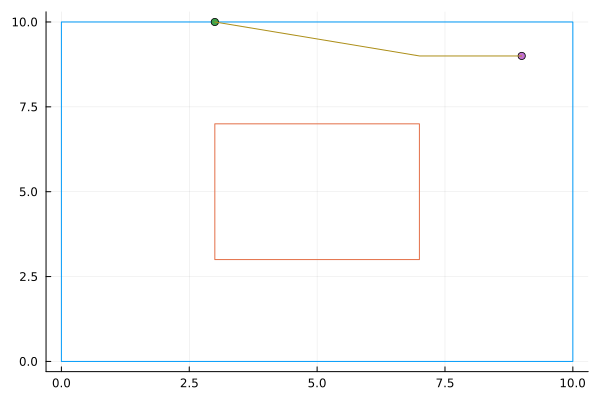

In [255]:
background = Background([Point(0,0), Point(10,0), Point(10,10), Point(0,10), Point(0,0)])
obstacle = Obstacle([Point(3,3), Point(7,3), Point(7,7), Point(3,7), Point(3,3)])

start = Point(3,10)
target = Point(9,9)

p = plot(map(p -> p.x, background.vertices), map(p -> p.y, background.vertices), legend=false)
plot!(p, map(p -> p.x, obstacle.vertices), map(p -> p.y, obstacle.vertices))
scatter!(p, [start.x], [start.y])
scatter!(p, [target.x], [target.y])

plot!(p, [3,3,3,7,7,7,7,9], [10,10,10,9,9,9,9,9])

In [626]:
A = [-1 0; 1 0; 0 -1; 0 1;];
b1 = [0; 3; 0; 10];
b2 = [-3; 7; -7; 10];
b3 = [-3; 7; 0; 3];
b4 = [-7; 10; 0; 10];

qs = [1;5];
qt = [9;5];

ys = 1;
yt = 1;

model = Model(HiGHS.Optimizer);

@variable(model, 0 <= y1 <= 1);
@variable(model, 0 <= y2 <= 1);
@variable(model, 0 <= y3 <= 1);
@variable(model, 0 <= y4 <= 1);

#@variable(model, y1, Bin);
#@variable(model, y2, Bin);
#@variable(model, y3, Bin);
#@variable(model, y4, Bin);

@variable(model, z10[i=1:2]);
@variable(model, z11[i=1:2]);
@variable(model, z20[i=1:2]);
@variable(model, z21[i=1:2]);
@variable(model, z30[i=1:2]);
@variable(model, z31[i=1:2]);
@variable(model, z40[i=1:2]);
@variable(model, z41[i=1:2]);

@variable(model, x1[i=1:2]);
@variable(model, x2[i=1:2]);
@variable(model, x3[i=1:2]);
@variable(model, x4[i=1:2]);

@constraint(model, z10 .== qs);
@constraint(model, z41 .== qt);

@constraint(model, y1 .== 1);
@constraint(model, y4 .== 1);

@constraint(model, A*z10 - b1*y1 .<= 0);
@constraint(model, A*z11 - b1*y1 .<= 0);
@constraint(model, A*z20 - b2*y2 .<= 0);
@constraint(model, A*z21 - b2*y2 .<= 0);
@constraint(model, A*z30 - b3*y3 .<= 0);
@constraint(model, A*z31 - b3*y3 .<= 0);
@constraint(model, A*z40 - b4*y4 .<= 0);
@constraint(model, A*z41 - b4*y4 .<= 0);
@constraint(model, A*z41 - b4*y4 .<= 0);

@constraint(model, z10 .>= 0);
@constraint(model, z11 .>= 0);
@constraint(model, z20 .>= 0);
@constraint(model, z21 .>= 0);
@constraint(model, z30 .>= 0);
@constraint(model, z31 .>= 0);
@constraint(model, z40 .>= 0);
@constraint(model, z41 .>= 0);

@constraint(model, z11 - z20 - z30 .== 0);
@constraint(model, z21 + z31 - z40 .== 0);

@constraint(model, y1 - y2 - y3 == 0);
@constraint(model, y2 + y3 - y4 == 0);

@constraint(model, z11 - z10 .<= x1);
@constraint(model, z10 - z11 .<= x1);

@constraint(model, z21 - z20 .<= x2);
@constraint(model, z20 - z21 .<= x2);

@constraint(model, z31 - z30 .<= x3);
@constraint(model, z30 - z31 .<= x3);

@constraint(model, z41 - z40 .<= x4);
@constraint(model, z40 - z41 .<= x4);

@objective(model, Min, x1[2] + x1[1] + x2[2] + x2[1] + x3[2] + x3[1] + x4[2] + x4[1])


print(model);

Min x1[2] + x1[1] + x2[2] + x2[1] + x3[2] + x3[1] + x4[2] + x4[1]
Subject to
 z10[1] = 1.0
 z10[2] = 5.0
 z41[1] = 9.0
 z41[2] = 5.0
 y1 = 1.0
 y4 = 1.0
 z11[1] - z20[1] - z30[1] = 0.0
 z11[2] - z20[2] - z30[2] = 0.0
 z21[1] + z31[1] - z40[1] = 0.0
 z21[2] + z31[2] - z40[2] = 0.0
 y1 - y2 - y3 = 0.0
 y2 + y3 - y4 = 0.0
 z10[1] ≥ 0.0
 z10[2] ≥ 0.0
 z11[1] ≥ 0.0
 z11[2] ≥ 0.0
 z20[1] ≥ 0.0
 z20[2] ≥ 0.0
 z21[1] ≥ 0.0
 z21[2] ≥ 0.0
 z30[1] ≥ 0.0
 z30[2] ≥ 0.0
 z31[1] ≥ 0.0
 z31[2] ≥ 0.0
 z40[1] ≥ 0.0
 z40[2] ≥ 0.0
 z41[1] ≥ 0.0
 z41[2] ≥ 0.0
 -z10[1] ≤ 0.0
 -3 y1 + z10[1] ≤ 0.0
 -z10[2] ≤ 0.0
 -10 y1 + z10[2] ≤ 0.0
 -z11[1] ≤ 0.0
 -3 y1 + z11[1] ≤ 0.0
 -z11[2] ≤ 0.0
 -10 y1 + z11[2] ≤ 0.0
 3 y2 - z20[1] ≤ 0.0
 -7 y2 + z20[1] ≤ 0.0
 7 y2 - z20[2] ≤ 0.0
 -10 y2 + z20[2] ≤ 0.0
 3 y2 - z21[1] ≤ 0.0
 -7 y2 + z21[1] ≤ 0.0
 7 y2 - z21[2] ≤ 0.0
 -10 y2 + z21[2] ≤ 0.0
 3 y3 - z30[1] ≤ 0.0
 -7 y3 + z30[1] ≤ 0.0
 -z30[2] ≤ 0.0
 -3 y3 + z30[2] ≤ 0.0
 3 y3 - z31[1] ≤ 0.0
 -7 y3 + z31[1] ≤ 0.0
 -z31[2]

In [627]:
optimize!(model)

Running HiGHS 1.3.0 [date: 1970-01-01, git hash: e5004072b-dirty]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
34 rows, 21 cols, 80 nonzeros
30 rows, 17 cols, 84 nonzeros
Presolve : Reductions: rows 30(-46); columns 17(-11); elements 84(-60)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -8.0000000000e+03 Ph1: 16(16000); Du: 8(8) 0s
         16     8.0000000000e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 16
Objective value     :  8.0000000000e+00
HiGHS run time      :          0.00


In [628]:
objective_value(model)

8.0

In [629]:
print(value(y1))
print("\n")
print(value(y2))
print("\n")
print(value(y3))
print("\n")
print(value(y4))
print("\n")

1.0
0.7142857142857143
0.2857142857142857
1.0


In [630]:
print(value.(z10))
print("\n")
print(value.(z11))
print("\n")
print(value.(z20))
print("\n")
print(value.(z21))
print("\n")
print(value.(z30))
print("\n")
print(value.(z31))
print("\n")
print(value.(z40))
print("\n")
print(value.(z41))
print("\n")

[1.0, 5.0]
[3.0, 5.0]
[2.142857142857143, 5.0]
[5.0, 5.0]
[0.8571428571428571, -0.0]
[2.0, -0.0]
[7.0, 5.0]
[9.0, 5.0]


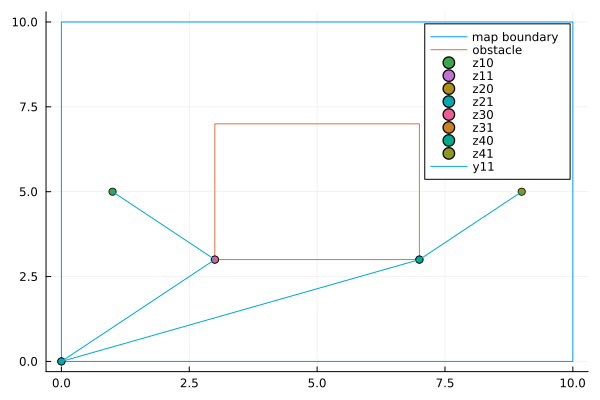

In [624]:
background = Background([Point(0,0), Point(10,0), Point(10,10), Point(0,10), Point(0,0)])
obstacle = Obstacle([Point(3,3), Point(7,3), Point(7,7), Point(3,7), Point(3,3)])

p = plot(map(p -> p.x, background.vertices), map(p -> p.y, background.vertices),label="map boundary")
plot!(p, map(p -> p.x, obstacle.vertices), map(p -> p.y, obstacle.vertices),label="obstacle")

scatter!(p, [value.(z10)[1]],[value.(z10)[2]],label="z10")
scatter!(p, [value.(z11)[1]],[value.(z11)[2]],label="z11")
scatter!(p, [value.(z20)[1]],[value.(z20)[2]],label="z20")
scatter!(p, [value.(z21)[1]],[value.(z21)[2]],label="z21")
scatter!(p, [value.(z30)[1]],[value.(z30)[2]],label="z30")
scatter!(p, [value.(z31)[1]],[value.(z31)[2]],label="z31")
scatter!(p, [value.(z40)[1]],[value.(z40)[2]],label="z40")
scatter!(p, [value.(z41)[1]],[value.(z41)[2]],label="z41")

plot!(p, [value.(z10)[1],value.(z11)[1],value.(z20)[1],value.(z21)[1],value.(z40)[1],value.(z41)[1]],[value.(z10)[2],value.(z11)[2],value.(z20)[2],value.(z21)[2],value.(z40)[2],value.(z41)[2]])


In [32]:
model = Model(HiGHS.Optimizer);

degree = 3;

# flow variables
@variable(model, 0 <= y[i = 1:size(myMap.freeRegions)[1]] <= 1);
@variable(model, yst[i = 1:2] .== 1);
@constraint(model, Ay*y - by*yst .== 0)

# control points
@variable(model, zs[i = 1:2]);
@variable(model, zt[i = 1:2]);

@variable(model, xs[i = 1:2]);
@variable(model, xt[i = 1:2]);

@variable(model, z[i=1:size(myMap.freeRegions)[1], j = 1:degree+1, k = 1:2]);
@variable(model, x[i=1:size(myMap.freeRegions)[1]*degree*2 - 3, j = 1:2] .>= 0);

@constraint(model, zs .== PointAsVector(myMap.sourcePoint))
@constraint(model, zt .== PointAsVector(myMap.targetPoint))

As, bs = GenerateContraintMatrixForSourceRegionFromMap(myMap)
At, bt = GenerateContraintMatrixForTargetRegionFromMap(myMap)

@constraint(model, As*zs - bs*yst[1] .<= 0);
@constraint(model, At*zt - bt*yst[2] .<= 0);

for i = 1:degree+1
    @constraint(model, As*z[1,i,:] - bs*yst[1] .<= 0);
    @constraint(model, At*z[4,i,:] - bt*yst[2] .<= 0);
end


for i = 2:3
    A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[i])
    for j = 1:degree+1
        @constraint(model, A*z[i,j,:] - b*y[i] .<= 0);
    end
end


for i = 1:size(myMap.freeRegions)[1]
    @constraint(model, z[i,1,:] - z[i,2,:] .<= x[(i-1)*6 + 1,:]);
    @constraint(model, z[i,2,:] - z[i,1,:] .<= x[(i-1)*6 + 1,:]);
    @constraint(model, z[i,3,:] - z[i,2,:] .<= x[(i-1)*6 + 2,:]);
    @constraint(model, z[i,2,:] - z[i,3,:] .<= x[(i-1)*6 + 2,:]);
    @constraint(model, z[i,4,:] - z[i,3,:] .<= x[(i-1)*6 + 3,:]);
    @constraint(model, z[i,3,:] - z[i,4,:] .<= x[(i-1)*6 + 3,:]);
end 


# flow constraint, how to represent? 
@constraint(model, z[1,1,:] .== zs);


@constraint(model, z[1,4,:] - z[2,1,:] - z[3,1,:] .== 0);
@constraint(model, z[2,4,:] + z[3,4,:] - z[4,1,:] .== 0);

@constraint(model, z[4,4,:] .== zt);

@objective(model, Min, sum(x));

print(model)

10-element LinRange{Float64, Int64}:
 0.0,0.111111,0.222222,0.333333,0.444444,…,0.666667,0.777778,0.888889,1.0

# Bézier Curves

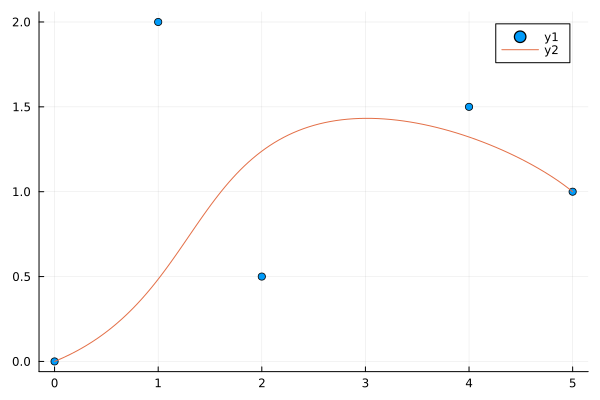

In [303]:
points::Vector{Point} = [Point(0,0),Point(2,0.5), Point(1,2), Point(4,1.5), Point(5,1)]
curve = BezierCurve(points,4)
p = scatter(map(c -> c.x, points), map(c -> c.y, points))
plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))

# Graphs

In [9]:
backgroundVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(backgroundVerticesList, Point(0,0))
PushIntoCircularPointList(backgroundVerticesList, Point(0,10))
PushIntoCircularPointList(backgroundVerticesList, Point(10,10))
PushIntoCircularPointList(backgroundVerticesList, Point(10,0))

background = Polygon(backgroundVerticesList);

In [10]:
obstacleOneVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(obstacleOneVerticesList, Point(2,2))
PushIntoCircularPointList(obstacleOneVerticesList, Point(2,8))
PushIntoCircularPointList(obstacleOneVerticesList, Point(6,8))
PushIntoCircularPointList(obstacleOneVerticesList, Point(6,2))

obstacleOne = Polygon(obstacleOneVerticesList);

obstacleTwoVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(obstacleTwoVerticesList, Point(7,6))
PushIntoCircularPointList(obstacleTwoVerticesList, Point(7,10))
PushIntoCircularPointList(obstacleTwoVerticesList, Point(10,10))
PushIntoCircularPointList(obstacleTwoVerticesList, Point(10,6))

obstacleTwo = Polygon(obstacleTwoVerticesList);

obstacleThreeVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(obstacleThreeVerticesList, Point(7,0))
PushIntoCircularPointList(obstacleThreeVerticesList, Point(7,4))
PushIntoCircularPointList(obstacleThreeVerticesList, Point(10,4))
PushIntoCircularPointList(obstacleThreeVerticesList, Point(10,0))

obstacleThree = Polygon(obstacleThreeVerticesList);

In [11]:
freeRegionOneVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(freeRegionOneVerticesList, Point(0,0))
PushIntoCircularPointList(freeRegionOneVerticesList, Point(0,10))
PushIntoCircularPointList(freeRegionOneVerticesList, Point(2,10))
PushIntoCircularPointList(freeRegionOneVerticesList, Point(2,0))

freeRegionOne = Polygon(freeRegionOneVerticesList);

freeRegionTwoVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(freeRegionTwoVerticesList, Point(2,8))
PushIntoCircularPointList(freeRegionTwoVerticesList, Point(2,10))
PushIntoCircularPointList(freeRegionTwoVerticesList, Point(6,10))
PushIntoCircularPointList(freeRegionTwoVerticesList, Point(6,8))

freeRegionTwo = Polygon(freeRegionTwoVerticesList);

freeRegionThreeVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(freeRegionThreeVerticesList, Point(2,0))
PushIntoCircularPointList(freeRegionThreeVerticesList, Point(2,2))
PushIntoCircularPointList(freeRegionThreeVerticesList, Point(6,2))
PushIntoCircularPointList(freeRegionThreeVerticesList, Point(6,0))

freeRegionThree = Polygon(freeRegionThreeVerticesList);

freeRegionFourVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(freeRegionFourVerticesList, Point(6,0))
PushIntoCircularPointList(freeRegionFourVerticesList, Point(6,10))
PushIntoCircularPointList(freeRegionFourVerticesList, Point(7,10))
PushIntoCircularPointList(freeRegionFourVerticesList, Point(7,0))

freeRegionFour = Polygon(freeRegionFourVerticesList);

freeRegionFiveVerticesList = CircularPointList(nothing, nothing,0)
PushIntoCircularPointList(freeRegionFiveVerticesList, Point(7,4))
PushIntoCircularPointList(freeRegionFiveVerticesList, Point(7,6))
PushIntoCircularPointList(freeRegionFiveVerticesList, Point(10,6))
PushIntoCircularPointList(freeRegionFiveVerticesList, Point(10,4))

freeRegionFive = Polygon(freeRegionFiveVerticesList);

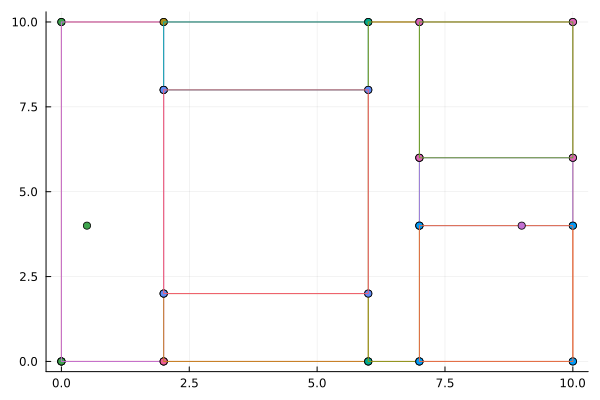

In [13]:
myMap = Map(background, [freeRegionOne, freeRegionTwo, freeRegionThree, freeRegionFour, freeRegionFive], [obstacleOne, obstacleTwo, obstacleThree], Point(0.5,4), Point(9,4));
PrintMap(myMap)

source: 1
target: 5


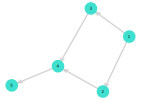

In [14]:
g = GenerateGraphOfConvexSetsFromMap(myMap)
gplot(g,nodelabel=1:5)

In [15]:
by = GenerateSourceMatrixFromMap(myMap)
Ay = Matrix(incidence_matrix(g))


5×5 Matrix{Int64}:
 -1  -1   0   0   0
  1   0  -1   0   0
  0   1   0  -1   0
  0   0   1   1  -1
  0   0   0   0   1

In [16]:
model = Model(HiGHS.Optimizer);

degree = 4;

# flow decision variables
@variable(model, 0 <= y[i = 1:size(myMap.freeRegions)[1]] <= 1);
@variable(model, yst[i = 1:2] .== 1);
@constraint(model, Ay*y - by*yst .== 0);

# cone variables
@variable(model, zs[i = 1:2]);
@variable(model, zt[i = 1:2]);
@variable(model, z[i=1:size(myMap.freeRegions)[1], j = 1:degree+1, k = 1:2]);

@constraint(model, zs .== PointAsVector(myMap.sourcePoint));
;@constraint(model, zt .== PointAsVector(myMap.targetPoint));

As, bs = GenerateContraintMatrixForSourceRegionFromMap(myMap);
At, bt = GenerateContraintMatrixForTargetRegionFromMap(myMap);

@constraint(model, As*zs - bs*yst[1] .<= 0);
@constraint(model, At*zt - bt*yst[2] .<= 0);

for i = 1:degree+1
    @constraint(model, As*z[1,i,:] - bs*yst[1] .<= 0);
    @constraint(model, At*z[5,i,:] - bt*yst[2] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[2]);
for j = 1:degree+1  
    @constraint(model, A*z[2,j,:] - b*y[1] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[3]);
for j = 1:degree+1  
    @constraint(model, A*z[3,j,:] - b*y[2] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[4]);
for j = 1:degree+1  
    @constraint(model, A*z[4,j,:] - b*y[5] .<= 0);
end

@constraint(model, z[1,1,:] .== zs);
@constraint(model, z[1,5,:] - z[2,1,:] - z[3,1,:] .== 0);
@constraint(model, z[2,5,:] + z[3,5,:] - z[4,1,:] .== 0);
@constraint(model, z[4,5,:] - z[5,1,:] .== 0);
@constraint(model, z[5,5,:] .== zt);

@constraint(model, (z[1,5,:]-z[1,4,:]) - (z[2,2,:] - z[2,1,:]) - (z[3,2,:] - z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-z[2,4,:]) + (z[3,5,:]-z[3,4,:]) - (z[4,2,:]-z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-z[4,4,:]) - (z[5,2,:]-z[5,1,:]) .== 0);

@constraint(model, (z[1,5,:]-2*z[1,4,:] + z[1,3,:]) - (z[2,3,:] - 2*z[2,2,:]+z[2,1,:]) - (z[3,3,:] - 2*z[3,2,:]+z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-2*z[2,4,:] + z[2,3,:]) + (z[3,5,:]-2*z[3,4,:]+z[3,5,:]) - (z[4,3,:] - 2*z[4,2,:]+z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-2*z[4,4,:] + z[4,3,:]) - (z[5,3,:]-2*z[5,2,:]+z[5,1,:]) .== 0);

@constraint(model, (z[1,5,:]-3*z[1,4,:] + 3*z[1,3,:] - z[1,2,:]) - (z[2,4,:]-3*z[2,3,:] + 3*z[2,2,:] - z[2,1,:]) - (z[3,4,:]-3*z[3,3,:] + 3*z[3,2,:] - z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-3*z[2,4,:] + 3*z[2,3,:] - z[2,2,:]) + (z[3,5,:]-3*z[3,4,:] + 3*z[3,3,:] - z[3,2,:]) - (z[4,4,:]-3*z[4,3,:] + 3*z[4,2,:] - z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-3*z[4,4,:] + 3*z[4,3,:] - z[4,2,:]) - (z[5,4,:]-3*z[5,3,:] + 3*z[5,2,:] - z[5,1,:]) .== 0);

@variable(model, x[i=1:size(myMap.freeRegions)[1]*degree, j = 1:2] .>= 0);
for i = 1:size(myMap.freeRegions)[1]
    @constraint(model, z[i,1,:] - z[i,2,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 1,:]);
    @constraint(model, z[i,2,:] - z[i,1,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 1,:]);

    @constraint(model, z[i,3,:] - z[i,2,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 2,:]);
    @constraint(model, z[i,2,:] - z[i,3,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 2,:]);

    @constraint(model, z[i,4,:] - z[i,3,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 3,:]);
    @constraint(model, z[i,3,:] - z[i,4,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 3,:]);

    @constraint(model, z[i,5,:] - z[i,4,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 4,:]);
    @constraint(model, z[i,4,:] - z[i,5,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 4,:]);
end 

maximumAcceleration = 2.5

for i = 1:size(myMap.freeRegions)[1]
    @constraint(model, degree*(z[i,3,:] - 2*z[i,2,:] + z[i,1,:]) .<= maximumAcceleration);
    @constraint(model, degree*(-z[i,3,:] + 2*z[i,2,:] - z[i,1,:]) .<= maximumAcceleration);
    
    @constraint(model, degree*(z[i,4,:] - 2*z[i,3,:] + z[i,2,:]) .<= maximumAcceleration);
    @constraint(model, degree*(-z[i,4,:] + 2*z[i,3,:] - z[i,2,:]) .<= maximumAcceleration);
end 

@objective(model, Min, sum(x));

In [17]:
optimize!(model)
relaxedValue = objective_value(model)

Running HiGHS 1.3.0 [date: 1970-01-01, git hash: e5004072b-dirty]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
213 rows, 86 cols, 597 nonzeros
168 rows, 78 cols, 536 nonzeros
147 rows, 77 cols, 482 nonzeros
Presolve : Reductions: rows 147(-118); columns 77(-24); elements 482(-254)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     9.9563628565e-11 Ph1: 61(67479); Du: 0(1.55152e-11) 0s
         63     9.2045454545e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 63
Objective value     :  9.2045454545e+00
HiGHS run time      :          0.00


9.20454545454545

In [18]:
print(value.(y))
print("\n")
yRounded = round.(value.(y))
print(yRounded)

[0.4, 0.6, 0.4, 0.6, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0]

In [19]:
model = Model(HiGHS.Optimizer);

degree = 4;

# flow decision variables
@variable(model, 0 <= y[i = 1:size(myMap.freeRegions)[1]] <= 1);
@variable(model, yst[i = 1:2] .== 1);
@constraint(model, Ay*y - by*yst .== 0);
@constraint(model, y  .== yRounded);

# cone variables
@variable(model, zs[i = 1:2]);
@variable(model, zt[i = 1:2]);
@variable(model, z[i=1:size(myMap.freeRegions)[1], j = 1:degree+1, k = 1:2]);

@constraint(model, zs .== PointAsVector(myMap.sourcePoint));
;@constraint(model, zt .== PointAsVector(myMap.targetPoint));

As, bs = GenerateContraintMatrixForSourceRegionFromMap(myMap);
At, bt = GenerateContraintMatrixForTargetRegionFromMap(myMap);

@constraint(model, As*zs - bs*yst[1] .<= 0);
@constraint(model, At*zt - bt*yst[2] .<= 0);

for i = 1:degree+1
    @constraint(model, As*z[1,i,:] - bs*yst[1] .<= 0);
    @constraint(model, At*z[5,i,:] - bt*yst[2] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[2]);
for j = 1:degree+1  
    @constraint(model, A*z[2,j,:] - b*y[1] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[3]);
for j = 1:degree+1  
    @constraint(model, A*z[3,j,:] - b*y[2] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[4]);
for j = 1:degree+1  
    @constraint(model, A*z[4,j,:] - b*y[5] .<= 0);
end

@constraint(model, z[1,1,:] .== zs);
@constraint(model, z[1,5,:] - z[2,1,:] - z[3,1,:] .== 0);
@constraint(model, z[2,5,:] + z[3,5,:] - z[4,1,:] .== 0);
@constraint(model, z[4,5,:] - z[5,1,:] .== 0);
@constraint(model, z[5,5,:] .== zt);

@constraint(model, (z[1,5,:]-z[1,4,:]) - (z[2,2,:] - z[2,1,:]) - (z[3,2,:] - z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-z[2,4,:]) + (z[3,5,:]-z[3,4,:]) - (z[4,2,:]-z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-z[4,4,:]) - (z[5,2,:]-z[5,1,:]) .== 0);

@constraint(model, (z[1,5,:]-2*z[1,4,:] + z[1,3,:]) - (z[2,3,:] - 2*z[2,2,:]+z[2,1,:]) - (z[3,3,:] - 2*z[3,2,:]+z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-2*z[2,4,:] + z[2,3,:]) + (z[3,5,:]-2*z[3,4,:]+z[3,5,:]) - (z[4,3,:] - 2*z[4,2,:]+z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-2*z[4,4,:] + z[4,3,:]) - (z[5,3,:]-2*z[5,2,:]+z[5,1,:]) .== 0);

@constraint(model, (z[1,5,:]-3*z[1,4,:] + 3*z[1,3,:] - z[1,2,:]) - (z[2,4,:]-3*z[2,3,:] + 3*z[2,2,:] - z[2,1,:]) - (z[3,4,:]-3*z[3,3,:] + 3*z[3,2,:] - z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-3*z[2,4,:] + 3*z[2,3,:] - z[2,2,:]) + (z[3,5,:]-3*z[3,4,:] + 3*z[3,3,:] - z[3,2,:]) - (z[4,4,:]-3*z[4,3,:] + 3*z[4,2,:] - z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-3*z[4,4,:] + 3*z[4,3,:] - z[4,2,:]) - (z[5,4,:]-3*z[5,3,:] + 3*z[5,2,:] - z[5,1,:]) .== 0);

@variable(model, x[i=1:size(myMap.freeRegions)[1]*degree, j = 1:2] .>= 0);
for i = 1:size(myMap.freeRegions)[1]
    @constraint(model, z[i,1,:] - z[i,2,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 1,:]);
    @constraint(model, z[i,2,:] - z[i,1,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 1,:]);

    @constraint(model, z[i,3,:] - z[i,2,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 2,:]);
    @constraint(model, z[i,2,:] - z[i,3,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 2,:]);

    @constraint(model, z[i,4,:] - z[i,3,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 3,:]);
    @constraint(model, z[i,3,:] - z[i,4,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 3,:]);

    @constraint(model, z[i,5,:] - z[i,4,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 4,:]);
    @constraint(model, z[i,4,:] - z[i,5,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 4,:]);
end 

maximumAcceleration = 2.5

for i = 1:size(myMap.freeRegions)[1]
    @constraint(model, degree*(z[i,3,:] - 2*z[i,2,:] + z[i,1,:]) .<= maximumAcceleration);
    @constraint(model, degree*(-z[i,3,:] + 2*z[i,2,:] - z[i,1,:]) .<= maximumAcceleration);
    
    @constraint(model, degree*(z[i,4,:] - 2*z[i,3,:] + z[i,2,:]) .<= maximumAcceleration);
    @constraint(model, degree*(-z[i,4,:] + 2*z[i,3,:] - z[i,2,:]) .<= maximumAcceleration);
end 

@objective(model, Min, sum(x));

In [20]:
optimize!(model)
roundedValue = objective_value(model)

Running HiGHS 1.3.0 [date: 1970-01-01, git hash: e5004072b-dirty]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
152 rows, 66 cols, 411 nonzeros
87 rows, 44 cols, 266 nonzeros
72 rows, 37 cols, 231 nonzeros
61 rows, 37 cols, 200 nonzeros
Presolve : Reductions: rows 61(-209); columns 37(-64); elements 200(-541)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
         40     1.5427001570e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 40
Objective value     :  1.5427001570e+01
HiGHS run time      :          0.00


15.427001569858698

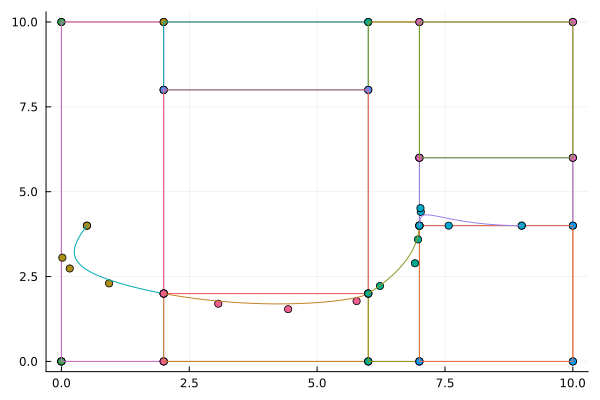

In [21]:
p = PrintMap(myMap)

points::Vector{Point} = [Point(value.(z[1,1,:])[1], value.(z[1,1,:])[2]),Point(value.(z[1,2,:])[1], value.(z[1,2,:])[2]), Point(value.(z[1,3,:])[1], value.(z[1,3,:])[2]),Point(value.(z[1,4,:])[1], value.(z[1,4,:])[2]),Point(value.(z[1,5,:])[1], value.(z[1,5,:])[2])]
curve = BezierCurve(points,4)
scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))

if yRounded[1] == 1
    points::Vector{Point} = [Point(value.(z[2,1,:])[1], value.(z[2,1,:])[2]),Point(value.(z[2,2,:])[1], value.(z[2,2,:])[2]), Point(value.(z[2,3,:])[1], value.(z[2,3,:])[2]),Point(value.(z[2,4,:])[1], value.(z[2,4,:])[2]),Point(value.(z[2,5,:])[1], value.(z[2,5,:])[2])]
    curve = BezierCurve(points,4)
    scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
    plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))
else
    points::Vector{Point} = [Point(value.(z[3,1,:])[1], value.(z[3,1,:])[2]),Point(value.(z[3,2,:])[1], value.(z[3,2,:])[2]), Point(value.(z[3,3,:])[1], value.(z[3,3,:])[2]),Point(value.(z[3,4,:])[1], value.(z[3,4,:])[2]),Point(value.(z[3,5,:])[1], value.(z[3,5,:])[2])]
    curve = BezierCurve(points,4)
    scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
    plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))
end

points::Vector{Point} = [Point(value.(z[4,1,:])[1], value.(z[4,1,:])[2]),Point(value.(z[4,2,:])[1], value.(z[4,2,:])[2]), Point(value.(z[4,3,:])[1], value.(z[4,3,:])[2]),Point(value.(z[4,4,:])[1], value.(z[4,4,:])[2]),Point(value.(z[4,5,:])[1], value.(z[4,5,:])[2])]
curve = BezierCurve(points,4)
scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))

points::Vector{Point} = [Point(value.(z[5,1,:])[1], value.(z[5,1,:])[2]),Point(value.(z[5,2,:])[1], value.(z[5,2,:])[2]), Point(value.(z[5,3,:])[1], value.(z[5,3,:])[2]),Point(value.(z[5,4,:])[1], value.(z[5,4,:])[2]),Point(value.(z[5,5,:])[1], value.(z[5,5,:])[2])]
curve = BezierCurve(points,4)
scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))

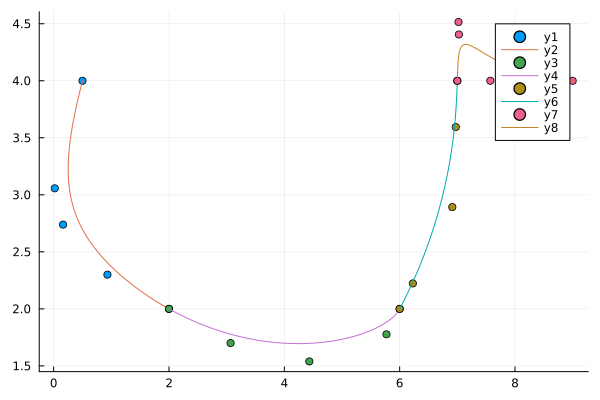

In [22]:

points::Vector{Point} = [Point(value.(z[1,1,:])[1], value.(z[1,1,:])[2]),Point(value.(z[1,2,:])[1], value.(z[1,2,:])[2]), Point(value.(z[1,3,:])[1], value.(z[1,3,:])[2]),Point(value.(z[1,4,:])[1], value.(z[1,4,:])[2]),Point(value.(z[1,5,:])[1], value.(z[1,5,:])[2])]
curve = BezierCurve(points,4)
p = scatter(map(c -> c.x, points), map(c -> c.y, points))
plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))

if yRounded[1] == 1
    points::Vector{Point} = [Point(value.(z[2,1,:])[1], value.(z[2,1,:])[2]),Point(value.(z[2,2,:])[1], value.(z[2,2,:])[2]), Point(value.(z[2,3,:])[1], value.(z[2,3,:])[2]),Point(value.(z[2,4,:])[1], value.(z[2,4,:])[2]),Point(value.(z[2,5,:])[1], value.(z[2,5,:])[2])]
    curve = BezierCurve(points,4)
    scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
    plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))
else
    points::Vector{Point} = [Point(value.(z[3,1,:])[1], value.(z[3,1,:])[2]),Point(value.(z[3,2,:])[1], value.(z[3,2,:])[2]), Point(value.(z[3,3,:])[1], value.(z[3,3,:])[2]),Point(value.(z[3,4,:])[1], value.(z[3,4,:])[2]),Point(value.(z[3,5,:])[1], value.(z[3,5,:])[2])]
    curve = BezierCurve(points,4)
    scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
    plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))
end

points::Vector{Point} = [Point(value.(z[4,1,:])[1], value.(z[4,1,:])[2]),Point(value.(z[4,2,:])[1], value.(z[4,2,:])[2]), Point(value.(z[4,3,:])[1], value.(z[4,3,:])[2]),Point(value.(z[4,4,:])[1], value.(z[4,4,:])[2]),Point(value.(z[4,5,:])[1], value.(z[4,5,:])[2])]
curve = BezierCurve(points,4)
scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))

points::Vector{Point} = [Point(value.(z[5,1,:])[1], value.(z[5,1,:])[2]),Point(value.(z[5,2,:])[1], value.(z[5,2,:])[2]), Point(value.(z[5,3,:])[1], value.(z[5,3,:])[2]),Point(value.(z[5,4,:])[1], value.(z[5,4,:])[2]),Point(value.(z[5,5,:])[1], value.(z[5,5,:])[2])]
curve = BezierCurve(points,4)
scatter!(p,map(c -> c.x, points), map(c -> c.y, points))
plot!(p,map(s -> EvaluateBezierCurve(curve,s)[1],LinRange(0,1,100)),map(s -> EvaluateBezierCurve(curve,s)[2],LinRange(0,1,100)))

In [23]:
model = Model(HiGHS.Optimizer);

degree = 4;

# flow decision variables
@variable(model, y[i = 1:size(myMap.freeRegions)[1]],Bin);
@variable(model, yst[i = 1:2] .== 1);
@constraint(model, Ay*y - by*yst .== 0);

# cone variables
@variable(model, zs[i = 1:2]);
@variable(model, zt[i = 1:2]);
@variable(model, z[i=1:size(myMap.freeRegions)[1], j = 1:degree+1, k = 1:2]);

@constraint(model, zs .== PointAsVector(myMap.sourcePoint));
;@constraint(model, zt .== PointAsVector(myMap.targetPoint));

As, bs = GenerateContraintMatrixForSourceRegionFromMap(myMap);
At, bt = GenerateContraintMatrixForTargetRegionFromMap(myMap);

@constraint(model, As*zs - bs*yst[1] .<= 0);
@constraint(model, At*zt - bt*yst[2] .<= 0);

for i = 1:degree+1
    @constraint(model, As*z[1,i,:] - bs*yst[1] .<= 0);
    @constraint(model, At*z[5,i,:] - bt*yst[2] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[2]);
for j = 1:degree+1  
    @constraint(model, A*z[2,j,:] - b*y[1] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[3]);
for j = 1:degree+1  
    @constraint(model, A*z[3,j,:] - b*y[2] .<= 0);
end

A,b = GeneratePolygonConstraintMatrix(myMap.freeRegions[4]);
for j = 1:degree+1  
    @constraint(model, A*z[4,j,:] - b*y[5] .<= 0);
end

@constraint(model, z[1,1,:] .== zs);
@constraint(model, z[1,5,:] - z[2,1,:] - z[3,1,:] .== 0);
@constraint(model, z[2,5,:] + z[3,5,:] - z[4,1,:] .== 0);
@constraint(model, z[4,5,:] - z[5,1,:] .== 0);
@constraint(model, z[5,5,:] .== zt);

@constraint(model, (z[1,5,:]-z[1,4,:]) - (z[2,2,:] - z[2,1,:]) - (z[3,2,:] - z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-z[2,4,:]) + (z[3,5,:]-z[3,4,:]) - (z[4,2,:]-z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-z[4,4,:]) - (z[5,2,:]-z[5,1,:]) .== 0);

@constraint(model, (z[1,5,:]-2*z[1,4,:] + z[1,3,:]) - (z[2,3,:] - 2*z[2,2,:]+z[2,1,:]) - (z[3,3,:] - 2*z[3,2,:]+z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-2*z[2,4,:] + z[2,3,:]) + (z[3,5,:]-2*z[3,4,:]+z[3,5,:]) - (z[4,3,:] - 2*z[4,2,:]+z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-2*z[4,4,:] + z[4,3,:]) - (z[5,3,:]-2*z[5,2,:]+z[5,1,:]) .== 0);

@constraint(model, (z[1,5,:]-3*z[1,4,:] + 3*z[1,3,:] - z[1,2,:]) - (z[2,4,:]-3*z[2,3,:] + 3*z[2,2,:] - z[2,1,:]) - (z[3,4,:]-3*z[3,3,:] + 3*z[3,2,:] - z[3,1,:]) .== 0);
@constraint(model, (z[2,5,:]-3*z[2,4,:] + 3*z[2,3,:] - z[2,2,:]) + (z[3,5,:]-3*z[3,4,:] + 3*z[3,3,:] - z[3,2,:]) - (z[4,4,:]-3*z[4,3,:] + 3*z[4,2,:] - z[4,1,:]) .== 0);
@constraint(model, (z[4,5,:]-3*z[4,4,:] + 3*z[4,3,:] - z[4,2,:]) - (z[5,4,:]-3*z[5,3,:] + 3*z[5,2,:] - z[5,1,:]) .== 0);

@variable(model, x[i=1:size(myMap.freeRegions)[1]*degree, j = 1:2] .>= 0);
for i = 1:size(myMap.freeRegions)[1]
    @constraint(model, z[i,1,:] - z[i,2,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 1,:]);
    @constraint(model, z[i,2,:] - z[i,1,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 1,:]);

    @constraint(model, z[i,3,:] - z[i,2,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 2,:]);
    @constraint(model, z[i,2,:] - z[i,3,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 2,:]);

    @constraint(model, z[i,4,:] - z[i,3,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 3,:]);
    @constraint(model, z[i,3,:] - z[i,4,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 3,:]);

    @constraint(model, z[i,5,:] - z[i,4,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 4,:]);
    @constraint(model, z[i,4,:] - z[i,5,:] .<= x[(i-1)*(size(myMap.freeRegions)[1]-1) + 4,:]);
end 

maximumAcceleration = 2.5

for i = 1:size(myMap.freeRegions)[1]
    @constraint(model, degree*(z[i,3,:] - 2*z[i,2,:] + z[i,1,:]) .<= maximumAcceleration);
    @constraint(model, degree*(-z[i,3,:] + 2*z[i,2,:] - z[i,1,:]) .<= maximumAcceleration);
    
    @constraint(model, degree*(z[i,4,:] - 2*z[i,3,:] + z[i,2,:]) .<= maximumAcceleration);
    @constraint(model, degree*(-z[i,4,:] + 2*z[i,3,:] - z[i,2,:]) .<= maximumAcceleration);
end 

@objective(model, Min, sum(x));

optimize!(model)
integralValue = objective_value(model)

Running HiGHS 1.3.0 [date: 1970-01-01, git hash: e5004072b-dirty]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
171 rows, 81 cols, 544 nonzeros
132 rows, 68 cols, 406 nonzeros
131 rows, 67 cols, 412 nonzeros

Solving MIP model with:
   131 rows
   67 cols (1 binary, 0 integer, 0 implied int., 66 continuous)
   412 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0.6761363636    inf                  inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   9.204545455     15.42700157       40.33%        0      0      0        43     0.0s
 T       0       0         0   0.00%   9.753156566     15.42700157       36.78%      119      5      0        89     0.0s

Solving report
  Status            Opt

15.427001569858554

In [24]:
relaxedValue

9.20454545454545

In [25]:
roundedValue

15.427001569858698

In [26]:
integralValue

15.427001569858554

In [28]:
integralityGap = 100*(roundedValue-integralValue)/integralValue

9.326822411980835e-13